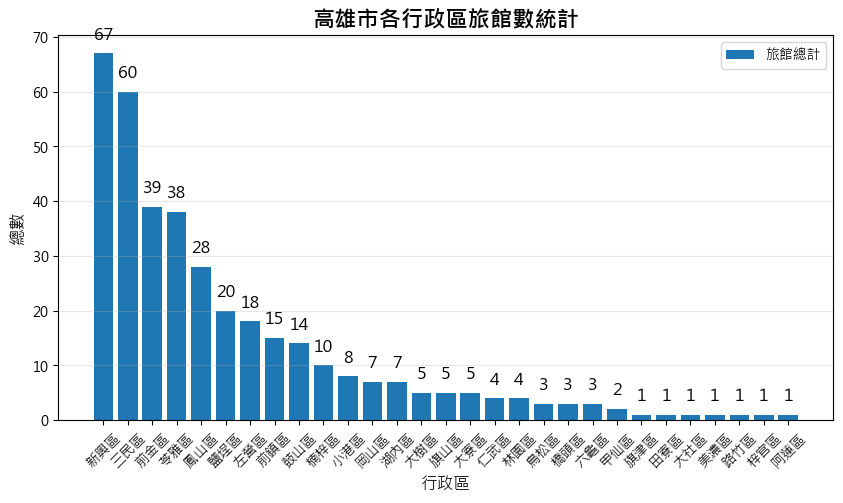

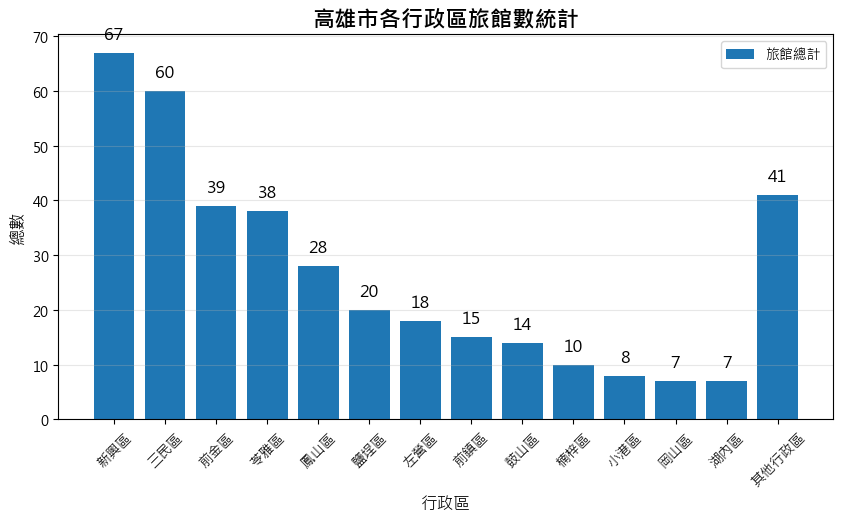

In [21]:
# 練習將旅館的資料寫入 MySQL，並讀取後畫成地區統計圖



import requests
import io
import csv
import pymysql
import pandas
import matplotlib.pyplot as plt



# 1. 先將網路的回應傳輸轉成檔案以 csv 方式讀取，並以 list 格式來呈現

response = requests.get("https://data.kcg.gov.tw/File/ResourceDownload/59e24315-4e78-4455-af5e-8c457600f286")

io_file = io.StringIO(response.content.decode())

data = list(csv.reader(io_file))

data_column , *data_row = data



# 2. 將資料寫入 MySQL

connection = pymysql.connect(

    host="127.0.0.1",
    user="root",
    database="example",
    password="12345",
    charset="utf8"

)

cursor = connection.cursor()

sql = "INSERT INTO new_table_6 (Seq, 序號, 類別, 星等, 旅宿名稱, 縣市, 鄉鎮, 地址, 電話, 傳真, 房間數, 電子郵件, 網址, 郵遞區號, 經度, 緯度, 資料序號) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

try : 

    cursor.executemany(sql,data_row)

    connection.commit()

except Exception as e : 

    connection.rollback()

    print("寫入失敗",e)

cursor.close()

connection.close()



# 3. 將資料用聚合函數方式統計後讀取出來

connection = pymysql.connect(

    host="127.0.0.1",
    user="root",
    database="example",
    password="12345",
    charset="utf8"

)

cursor = connection.cursor()

# 可以先放在 MySQL 跑跑看，可以執行再拿過來用

sql = "SELECT 縣市 , 鄉鎮 , COUNT(*) as 各鄉鎮總旅館數 FROM new_table_6 GROUP BY 縣市 , 鄉鎮 ORDER BY 各鄉鎮總旅館數 DESC"

column = cursor.execute(sql)

column = [desc[0] for desc in cursor.description]

result = cursor.fetchall()

cursor.close()

connection.close()



# 4. 將結果畫成長條圖統計

# 先將資料轉成 pandas dataframe 來操作

dataframe = pandas.DataFrame(result, columns = column)

x = dataframe["鄉鎮"]

y = dataframe["各鄉鎮總旅館數"]

# 再進行畫圖

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei" , "Simhei"]
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(10,5))

plt.bar(x,y,label="旅館總計")

for i , item in enumerate(y) : 

    plt.annotate(f"{item}",(i,item),textcoords="offset points",xytext=(0,10),ha="center",fontsize=12)

plt.title("高雄市各行政區旅館數統計",fontsize=16,fontweight="bold")
plt.xlabel("行政區",fontsize=12)
plt.ylabel("總數",fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis="y",alpha=0.3)
plt.legend()

plt.show()



# 4.1 將資料做調整，數量小於 5 的區域就合併在一起

# 先找出主要的區域

dataframe_city = dataframe[dataframe["各鄉鎮總旅館數"]>5]

# 將較少總數區域也區分出來，並把數量合在一起

dataframe_county = dataframe[dataframe["各鄉鎮總旅館數"]<=5]

# 記得要用二維矩陣，有行列概念，來讓 dataframe 知道是一列的一筆資料

dataframe_county = pandas.DataFrame([["高雄市","其他行政區",sum(dataframe_county["各鄉鎮總旅館數"])]],columns=list(dataframe_county.columns))

# 將主要區域和少數區域資料合在一起，用有 y 軸概念的 concat

dataframe_combine = pandas.concat([dataframe_city,dataframe_county])

# 再進行畫圖

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei" , "Simhei"]
plt.rcParams["axes.unicode_minus"] = False

x = dataframe_combine["鄉鎮"]

y = dataframe_combine["各鄉鎮總旅館數"]

plt.figure(figsize=(10,5))

plt.bar(x,y,label="旅館總計")

for i , item in enumerate(y) : 

    plt.annotate(f"{item}",(i,item),textcoords="offset points",xytext=(0,10),ha="center",fontsize=12)

plt.title("高雄市各行政區旅館數統計",fontsize=16,fontweight="bold")
plt.xlabel("行政區",fontsize=12)
plt.ylabel("總數",fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis="y",alpha=0.3)
plt.legend()

plt.show()


